# Advanced regridding of data

In this notebook we will explore some of the interpolation methods provided by the [Regrid](../gen_files/icon_functions/regrid.rst) module. If no interpolation methods are specified, it will try to use a reasonable default for the given data (either linear or nearest neighbour); but if you understand your data and know what signal you want to preserve when you regrid it, there is a wealth of options to choose from. In this note book we will look at two examples:

* interpolate NetCDF-based fire danger index data, preserving the highest warning levels
* interpolate GRIB-based precipitation data, using a method that conserves total values

For clarity in the plots, we will restrict ourselves to data on regular lat/lon grids. However, many other grids, such as reduced Gaussian, are also supported.

## Preparations

We will only require the metview module for this example unless we wish to download data from the CDS.

In [1]:
import metview as mv

## Preserving maximum values when regridding fire danger index data

We [**retrieve**](../gen_files/icon_functions/retrieve.rst) or [**read**](../gen_files/icon_functions/read.rst) a fire danger risk forecast from the **CDS** - it comes on a **0.25 degree grid**.

The data comes from: https://cds.climate.copernicus.eu/cdsapp#!/dataset/cems-fire-historical?tab=overview.

In [2]:
use_cds = False # if False, then read data from disk

In [3]:
if use_cds:
    import zipfile
    import cdsapi
    c = cdsapi.Client()
    c.retrieve(
        'cems-fire-historical',
        {
            'format': 'zip',
            'product_type': 'reanalysis',
            'variable': [
                'danger_risk',
            ],
            'version': '3.1',
            'dataset': 'Consolidated dataset',
            'year': '2020',
            'month': '05',
            'day': '15',
        },
        'fire.zip')
    with zipfile.ZipFile('fire.zip', 'r') as zip_ref:
        zip_ref.extractall('.')
    fire = mv.read("ECMWF_FWI_DANGER_RISK_20200515_1200_hr_v3.1_con.nc")
else:
    filename = "ECMWF_FWI_DANGER_RISK_20200515_1200_hr_v3.1_con.nc"
    if mv.exist(filename):
        fire = mv.read(filename)
    else:
        fire = mv.gallery.load_dataset(filename)

### Initial plot
We will first plot the data on a global map using the *cell_shading* technique for speed. The data is in [NetCDF](../data_types/netcdf.rst) format, and we can inspect its variables so that we know what to plot.

In [4]:
fire.variables()

['time', 'longitude', 'latitude', 'danger_risk']

In [5]:
nvis = mv.netcdf_visualiser(netcdf_data=fire, 
                            netcdf_plot_type='geo_matrix',
                            netcdf_latitude_variable='latitude',
                            netcdf_longitude_variable='longitude',
                            netcdf_value_variable='danger_risk')

fire_shade_cell = mv.mcont(legend='on',
                      contour='off',
                      contour_level_selection_type='interval',
                      contour_interval=1,
                      contour_min_level=1,
                      contour_max_level=7,
                      contour_shade='on',
                      contour_shade_technique='cell_shading',
                      contour_shade_cell_resolution=20,
                      contour_shade_colour_method='palette',
                      contour_shade_palette_name='colorbrewer_Reds_6_r')

Since this is the first time we've created a plot in this notebook, we tell Metview to generate the plot inline and increase the font size a little.

In [6]:
mv.setoutput('jupyter', output_font_scale=1.5, plot_widget=False)

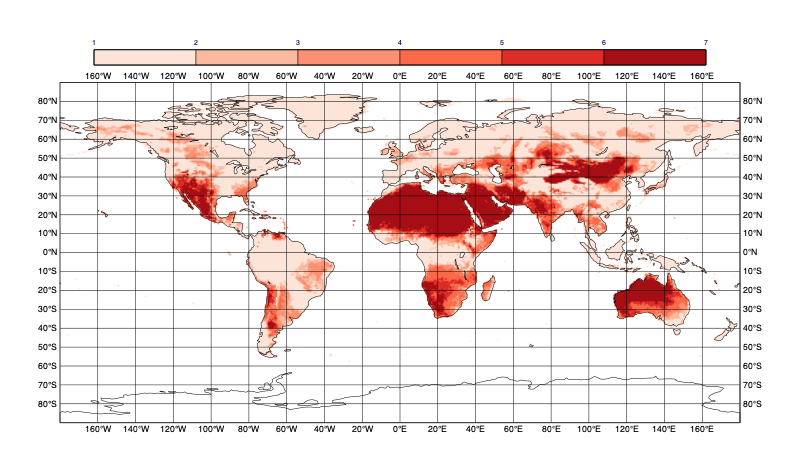

In [7]:
mv.plot(nvis, fire_shade_cell)

Now let's zoom into a smaller area and use the *grid_shading* technique to ensure we are plotting the exact grid cells as they appear in the data with no interpolations introduced by the plotting.

In [8]:
fire_shade_grid = mv.mcont(legend='on',
                      contour='off',
                      contour_level_selection_type='interval',
                      contour_interval=1,
                      contour_min_level=1,
                      contour_max_level=7,
                      contour_shade='on',
                      contour_shade_technique='grid_shading',
                      contour_shade_cell_resolution=20,
                      contour_shade_colour_method='palette',
                      contour_shade_palette_name='colorbrewer_Reds_6_r')

crete_map = mv.geoview(map_area_definition='corners',
                       area=[34, 22.5, 36, 27.5]) # [S,W,N,E]

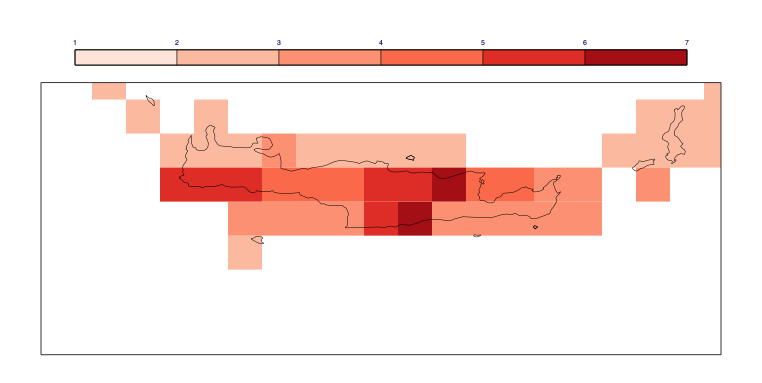

In [9]:
mv.plot(crete_map, nvis, fire_shade_grid)

We will regrid this data to a 1x1 degree grid cropped to an area of [33.2, 21.2, 38, 28] (S,W,N,E) - this is offset from the original grid in order to better illustrate the point. We'll use a trick to plot the target grid by using the grid from the coastlines.

In [10]:
coast = mv.mcoast(map_coastline_thickness=1,
                  map_grid_thickness=2,
                  map_grid_colour="kelly_green",
                  map_grid_latitude_increment=1,
                  map_grid_longitude_increment=1,
                  map_grid_latitude_reference=33.2-0.5,
                  map_grid_longitude_reference=21.2-0.5)

crete_map = mv.geoview(map_area_definition='corners',
                       area=[34, 22.5, 36, 27.5],
                       coastlines=coast)

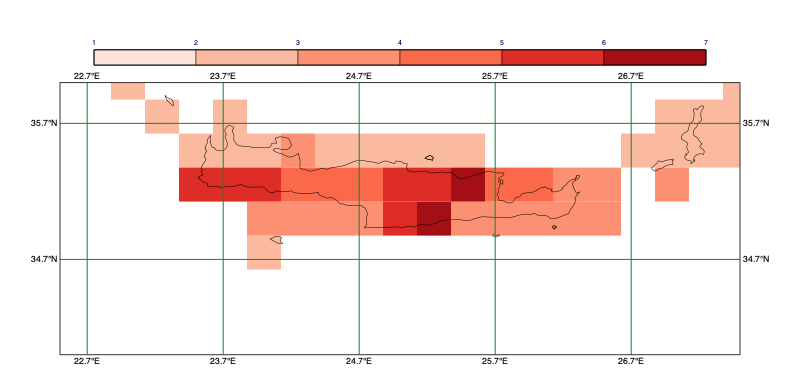

In [11]:
mv.plot(crete_map, nvis, fire_shade_grid)

To complete our initial plotting of the data, we will perform a simple regridding just to get the coordinates of the target grid points, replacing any missing values with real values, then plot the locations of these points over the original data. The target grid specification will be put into a dict so that we can re-use it with a different regridding technique later.

In [12]:
target_grid = {'grid':[1,1], 'area':[33.2, 21.2, 38, 28]} # S,W,N,E

In [13]:
fire_1x1_target_grid = mv.regrid(target_grid,
                                 data=fire)
fire_1x1_target_grid = fire_1x1_target_grid.nobitmap(0)

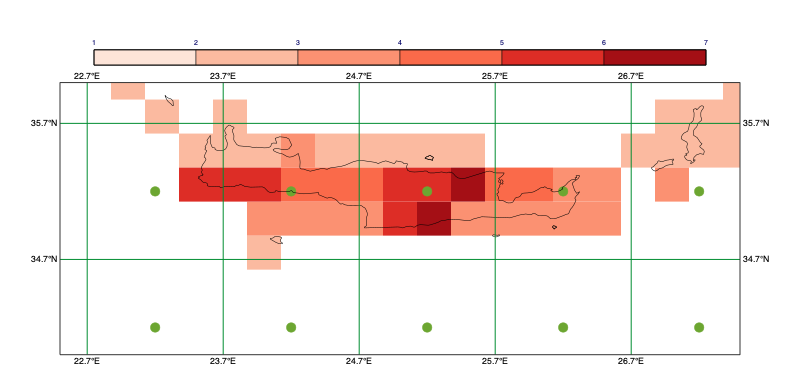

In [14]:
target_gridpoint_vis = mv.mcont(contour='off',
                                contour_grid_value_plot='on',
                                contour_grid_value_plot_type='marker',
                                contour_grid_value_marker_colour='avocado',
                                contour_grid_value_marker_index=15,
                                contour_grid_value_marker_height=0.7)

empty_title = mv.mtext(text_line_count=0)

mv.plot(crete_map,
        nvis, fire_shade_grid,
        fire_1x1_target_grid, target_gridpoint_vis,
        empty_title)

### Regridding via nearest neighbour technique
We will first use a common technique - for each target point, select the source point that is closest to it. As we will see, this method, although often useful, throws away a lot of data.

In [15]:
fire_1x1_nearest = mv.regrid(target_grid,
                             data=fire,
                             interpolation='nearest_neighbour')

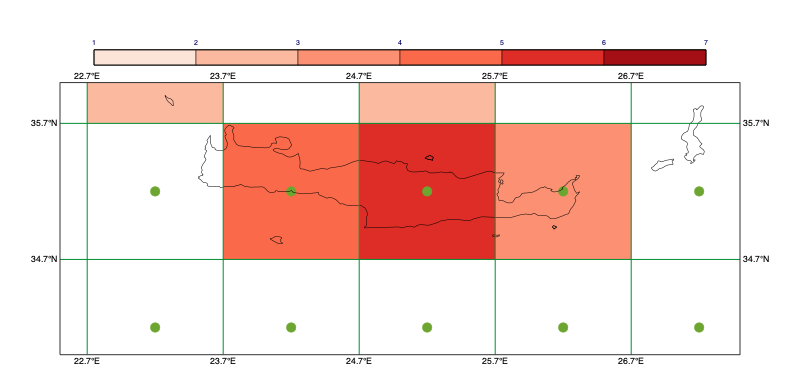

In [16]:
mv.plot(crete_map, 
        fire_1x1_nearest, fire_shade_grid,
        fire_1x1_target_grid, target_gridpoint_vis,
        empty_title)

As you can see by comparing this plot to the previous one, the source value closest to each target point (green dots) was chosen, and the rest of the source values were not used at all; some target grid boxes ended up with a risk level of zero, even though they cover an area where the original data contained larger risk values.

### Regridding via grid box maximum technique
Let's use a different regridding technique to use instead the maximum source value from each target grid box.

In [17]:
fire_1x1_max = mv.regrid(target_grid,
                         data=fire,
                         interpolation='grid_box_statistics',
                         interpolation_statistics='maximum')

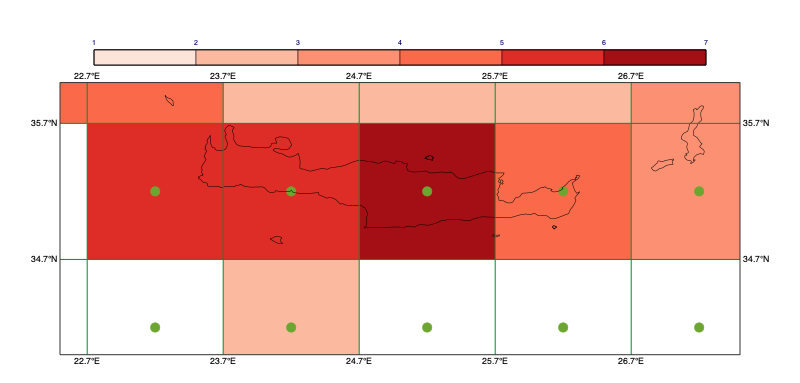

In [18]:
mv.plot(crete_map,
        fire_1x1_max, fire_shade_grid,
        fire_1x1_target_grid, target_gridpoint_vis,
        empty_title)

We now preserve the maximum risk level from each area. Note that this may or may not be what you want to do with this data - the regridding technique you use is up to you!

## Conserving total precipitation when regridding
In order to introduce the concept of conservative interpolation, we will use **total precipitation** GRIB data retrieved from MARS or read from disk. The source data will be on a 1x1 degree grid, and we will aim to put it onto a much lower resolution 5x5 degree grid while preserving the total quantity of precipitation both within each target grid box and overall.

In [19]:
use_mars = False # if False, then read data from disk

In [20]:
if use_mars: 
    precip = mv.retrieve(type='fc', 
                levType = 'sfc',
                param = 'tp', 
                date = 20111215, 
                time = 12,
                step = 12,            
                grid = [1, 1])
else:
    filename = "precip_1x1_global.grib"
    if mv.exist(filename):
        precip = mv.read(filename)
    else:
        precip = mv.gallery.load_dataset(filename)

Let's start by plotting the original data zoomed into a small area for closer study. We will use the [mcoast()](../gen_files/icon_functions/mcoast.rst) parameters to draw a 1x1 degree grid to show the original grid boxes more clearly. The grid points themselves are on exact 1-degree coordinates, so their cell bounds are on 0.5-degree coordinates.

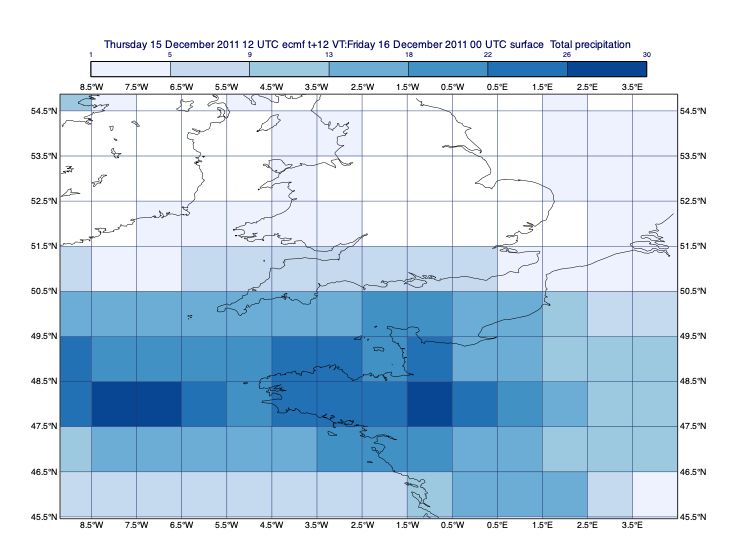

In [22]:
grid_shade = mv.mcont(
    legend                         = "on",
    contour                        = "off",
    contour_level_selection_type   = "level_list",
    contour_level_list             = [1,5,9,13,18,22,26,30],
    contour_shade                  = "on",
    contour_shade_technique        = "grid_shading",
    contour_shade_colour_method    = "palette",
    contour_shade_palette_name     = "colorbrewer_Blues_7_r",
    grib_scaling_of_derived_fields = "on"
    )

coastlines = mv.mcoast(
    map_grid_colour              = "RGB(0.1358,0.201,0.4367)",
    map_grid_latitude_reference  = 0.5,
    map_grid_latitude_increment  = 1,
    map_grid_longitude_reference = 0.5,
    map_grid_longitude_increment = 1
    )

view = mv.geoview(
    map_area_definition = "corners",
    area                = [45.46,-9.2,54.87,4.5],
    coastlines          = coastlines
    )

mv.plot(view, precip, grid_shade)

Now, to give us a visual reference, let's compute the bounds of one of the 5-degree target grid boxes and draw it over the map.

In [23]:
cb = [47.5, -7.5, 52.5, -2.5] # cell bounds (S,W,N,E)
cell_points_lats = [cb[0], cb[2], cb[2], cb[0], cb[0]]
cell_points_lons = [cb[1], cb[1], cb[3], cb[3], cb[1]]
cell_bounds_plot = mv.mvl_geopolyline(cell_points_lats, cell_points_lons, 0.1)

cell_bounds_style = mv.mgraph(
    graph_line_colour    = "red",
    graph_line_thickness = 5
    )

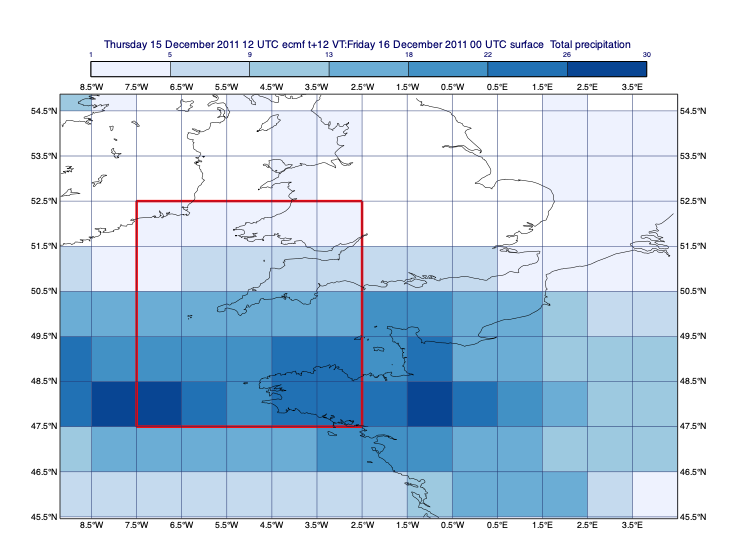

In [24]:
mv.plot(view, precip, grid_shade, cell_bounds_plot, cell_bounds_style)

Now use the *grid box average* technique to regrid the data. Since we will later inspect some exact values, we should increase the accuracy of the output data to 40 bits per value (the default is to take the accuracy of the input data, which in this case is 16 bits per value).

In [25]:
regrid_gbav = mv.regrid(
    grid          = [5,5],
    interpolation = "grid_box_average",
    data          = precip,
    accuracy      = 40
)

Plot it, still showing our target grid box of interest.

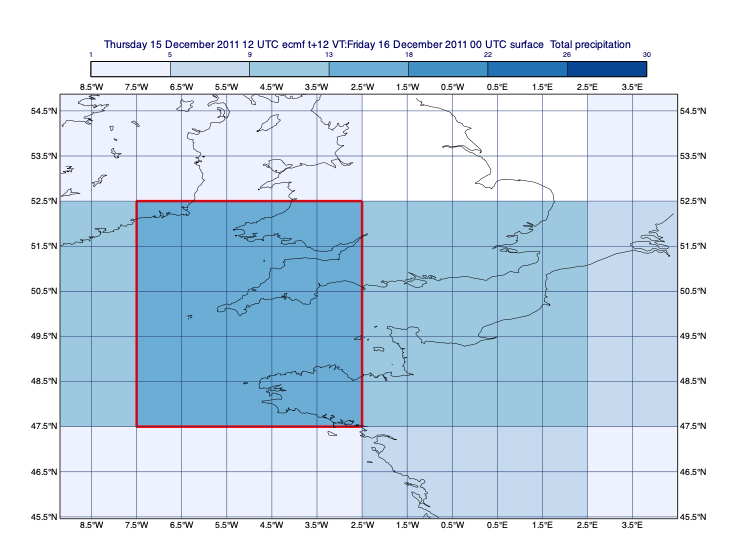

In [26]:
mv.plot(view, regrid_gbav, grid_shade, cell_bounds_plot, cell_bounds_style)

This new data should have two interesting properties because of the interpolation technique used:
1. the total value across the globe should be the same as in the original data (global conservation)
2. the value of each new grid box should be the same as the total value across the same area of the original data (local conservation)

Let's check - global values first, then local, again increasing the accuracy of the GRIB-based calculations.

In [27]:
mv.gribsetbits(40)

0.0

In [29]:
print("Global integral of source data:", precip.integral(), precip.grib_get_string("units"))
print("Global integral of target data:", regrid_gbav.integral(), regrid_gbav.grib_get_string("units"))

Global integral of source data: 831189515069.5703 m
Global integral of target data: 831189515069.875 m


In [30]:
print("Global weighted average of source data:", precip.integrate()*1000, "mm")
print("Global weighted average of target data:", regrid_gbav.integrate()*1000, "mm")

Global weighted average of source data: 1.6295368089254154 mm
Global weighted average of target data: 1.6310022921847311 mm


In [31]:
print("Local weighted average of 5x5 cell in source data:", precip.integrate(cb)*1000, "mm")
print("Local weighted average of 5x5 cell in target data:", regrid_gbav.integrate(cb)*1000, "mm")

Local weighted average of 5x5 cell in source data: 13.645306566508662 mm
Local weighted average of 5x5 cell in target data: 13.645306566502313 mm
